Notebook edited by ADK and then momentsLD data is added back in.
Dadi analysis is updated by Andy, and then Jiseon reduced the chunk size to ensure the number of chunks is actually 100. (can be less than if there aren't any SNPs in the interval)

This notebook is for comparing sbi's joint posterior distribution to dadi Godambe uncertainty interval. 
We use the 2-epoch model of Arabidopsis in stdpopsim with fixed ancestral population size to 1e4. 
Training data is prepared by simulating 10Mb leftmost segment of Chr1.
Dadi uses normalized and polarized site-frequency-spectrum of the tree sequence, and sbi can use the same summary statistics or moments of LD statistics or even raw genotype matrix with positional information appended.
We assume uniform prior distribution between the lower and higher bound of bottleneck time and current population size, so the posterior is proportional to the likelihood function.
We measure the coverage probability at 1000 randomly sample parameter value on each of the two marginal distributions. 

In [2]:
import stdpopsim
species = stdpopsim.get_species("AraTha")
model = species.get_demographic_model("African2Epoch_1H18")

nu_true = model.populations[0].initial_size / model.model.events[0].initial_size
T_true = model.model.events[0].time / (2 * model.model.events[0].initial_size)

upper_bound = [1, 1.5]
lower_bound = [1e-2, 1e-2]


/gpfs/home/jiseonm/micromamba/envs/popgensbi_env/lib/python3.12/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/gpfs/home/jiseonm/micromamba/envs/popgensbi_env/lib/python3.12/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [3]:
import dadi
import dadi.Godambe
import nlopt
import pandas as pd
import seaborn as sns
import os
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps

plt.rcParams.update({"font.size": 22})

In [4]:
import random
import tskit

# Dadi Analysis

In [4]:
# Find MLE
import tskit
import random
import glob

ts = tskit.load("ts_obs.trees")
# make vcf file
with open("ts_obs.vcf", "w") as f:
    ts.write_vcf(f)

# modify the vcf file to add the ancestral allele in info field
# used an awk script
# awk 'BEGIN {FS="\t"; OFS="\t"}
#        /^#/ {print $0; next}
#     {$8="AA=" $4; print $0}' plots/ts_obs.vcf > plots/ts_obs_modified.vcf
# bootstrap the vcf files
datafile = ("ts_obs_modified.vcf")

# make popinfo file
with open("ts_obs.popinfo.txt", "w") as f:
    f.write("SAMPLE POP\n")
    for i in range(10):
        f.write(f"tsk_{i} pop0\n")

# make dadi datadict file
dd = dadi.Misc.make_data_dict_vcf(datafile, "ts_obs.popinfo.txt")
pop_ids, ns = ["pop0"], [20]
fs = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)

In [5]:
ns = fs.sample_sizes
pts = 100
pts_l = [max(ns) + 120, max(ns) + 130, max(ns) + 140]
func = dadi.Demographics1D.two_epoch
func_ex = dadi.Numerics.make_extrap_func(func)

def find_dadi_MLE(obs_sfs):
    '''
    Repeat optimization 1000 times to get MLE
    Return MLE and composite-loglikelihood
    '''
    MLEs = []
    ll_list = []
    for i in range(100):
        np.random.seed(1357+i)
        random.seed(1357+i)
        p0 = [1,1]
        p0 = dadi.Misc.perturb_params(p0, fold=1, upper_bound=upper_bound, lower_bound=lower_bound)
        popt, ll_model = dadi.Inference.opt(
            p0,
            obs_sfs,
            func_ex,
            pts_l,
            lower_bound=lower_bound,
            upper_bound=upper_bound,
            verbose=len(p0),
            algorithm=nlopt.LN_BOBYQA,
            maxeval=600,
        )
        MLEs.append(popt)
        #model = func_ex(list(popt), ns, pts)
        ll_list.append(ll_model)
    best_idx = np.argmax(ll_list)
    return MLEs[best_idx], ll_list[best_idx]


# I'm not sure why but the MLE doesn't seem to converge well when dadi.opt was run with SFS, and it converges faster when run with normalized SFS
# Theoretically, rescaling sfs shouldn't affect the MLE because it also should find the optimal theta to rescale sfs with
# but it does affect the convergence time, so I will use normalized sfs to find MLE
MLE, ll = find_dadi_MLE(fs/fs.sum())
np.save("dadi_mle_redo.npy", MLE)



2       , -3.1466     , array([ 0.856646   ,  1.40993    ])
4       , -3.14609    , array([ 0.361646   ,  1.40993    ])
6       , -3.1423     , array([ 0.599067   ,  1.27488    ])
8       , -3.13817    , array([ 0.595964   ,  0.86977    ])
10      , -3.1445     , array([ 0.702497   ,  0.0603041  ])
12      , -3.13539    , array([ 0.367102   ,  0.703285   ])
14      , -3.13509    , array([ 0.423223   ,  0.63367    ])
16      , -3.13522    , array([ 0.236758   ,  0.594134   ])
18      , -3.135      , array([ 0.30214    ,  0.595193   ])
20      , -3.13499    , array([ 0.28549    ,  0.592229   ])
22      , -3.13499    , array([ 0.289114   ,  0.591306   ])
24      , -3.1499     , array([ 0.99       ,  1.28653    ])
26      , -3.14994    , array([ 0.99       ,  1.44663    ])
28      , -3.14985    , array([ 0.99       ,  1.12642    ])
30      , -3.14887    , array([ 0.960396   ,  1.19682    ])
32      , -3.14705    , array([ 0.8886     ,  0.113716   ])
34      , -3.14576    , array([ 0.788013

In [6]:
import tskit
import random
import glob

ts = tskit.load("ts_obs.trees")
# make vcf file
with open("ts_obs.vcf", "w") as f:
    ts.write_vcf(f)

# modify the vcf file to add the ancestral allele in info field
# used an awk script
# awk 'BEGIN {FS="\t"; OFS="\t"}
#        /^#/ {print $0; next}
#     {$8="AA=" $4; print $0}' plots/ts_obs.vcf > plots/ts_obs_modified.vcf
# bootstrap the vcf files
datafile = ("ts_obs_modified.vcf")

# make popinfo file
with open("ts_obs.popinfo.txt", "w") as f:
    f.write("SAMPLE POP\n")
    for i in range(10):
        f.write(f"tsk_{i} pop0\n")

# make dadi datadict file
dd = dadi.Misc.make_data_dict_vcf(datafile, "ts_obs.popinfo.txt")
pop_ids, ns = ["pop0"], [20]
fs = dadi.Spectrum.from_data_dict(dd, pop_ids, ns)



Nboot = 100
# dadi fragment data dict without overlap, so chunk_size should be at most sequence length / Nboot. 
# If not, the number of bootstraps will be less than Nboot.
chunk_size = ts.sequence_length / Nboot
chunks = dadi.Misc.fragment_data_dict(dd, chunk_size)




# Get a list containin the SFS of the bootstraped genomes.
boots = dadi.Misc.bootstraps_from_dd_chunks(chunks, Nboot, pop_ids, ns)

# Save the bootstraps
os.makedirs("boots", exist_ok=True)
for i in range(len(boots)):
    boots[i].to_file(
        "boots/ts_obs_modified.boot_{0}.fs".format(str(i))
    )
# GIM estimation

boots_fids = glob.glob("boots/*.fs")
boots_fs = [dadi.Spectrum.from_file(fid) for fid in boots_fids]

# Godambe uncertainties
# Will contain uncertainties for the
# estimated demographic parameters and theta.
random.seed(1357)
np.random.seed(1357)
uncerts_adj, GIM, H = dadi.Godambe.GIM_uncert(
    func_ex,
    pts_l,
    boots_fs,
    MLE,
    fs,
    eps=0.001,
    return_GIM=True,
    multinom=False,
)
cov = np.linalg.inv(GIM)
print(cov)
np.save("godambe_cov_redo.npy", cov)

[[0.02004037 0.06089732]
 [0.06089732 0.18505985]]


In [7]:
npe_sfs_samples = np.load("NPE_sfs_samples.npy")
npe_momentsLD_samples = np.load("NPE_momentsLD_samples.npy")
npe_end2end_samples = np.load("NPE_end2end_500SNPs_samples.npy")

In [8]:
MLE = np.load("dadi_mle_redo.npy")
cov = np.load("godambe_cov_redo.npy")

In [9]:
# Create separate arrays for nu and T
nu_array = np.concatenate(
    [npe_sfs_samples[:, 0], npe_momentsLD_samples[:,0], npe_end2end_samples[:, 0]] 
)

T_array = np.concatenate(
    [npe_sfs_samples[:, 1], npe_momentsLD_samples[:, 1], npe_end2end_samples[:, 1]]
)

# Create the method array
method_array = (
    ["SFS + no embedding"] * len(npe_sfs_samples)
    + ["momentsLD + MLP"] * len(npe_momentsLD_samples)
    + ["genotype matrix + ExchangeableCNN"] * len(npe_end2end_samples)
)

# Create the DataFrame
posterior_pd = pd.DataFrame({"nu": nu_array, "T": T_array, "method": method_array})
posterior_pd

,nu,T,method
0,0.196208,0.498285,SFS + no embedding
1,0.227444,0.520909,SFS + no embedding
2,0.055105,0.209684,SFS + no embedding
3,0.079379,0.274130,SFS + no embedding
4,0.334382,0.569315,SFS + no embedding
...,...,...,...
299995,0.101543,0.466277,genotype matrix + ExchangeableCNN
299996,0.179159,0.429905,genotype matrix + ExchangeableCNN
299997,0.147949,0.394371,genotype matrix + ExchangeableCNN
299998,0.123076,0.372362,genotype matrix + ExchangeableCNN


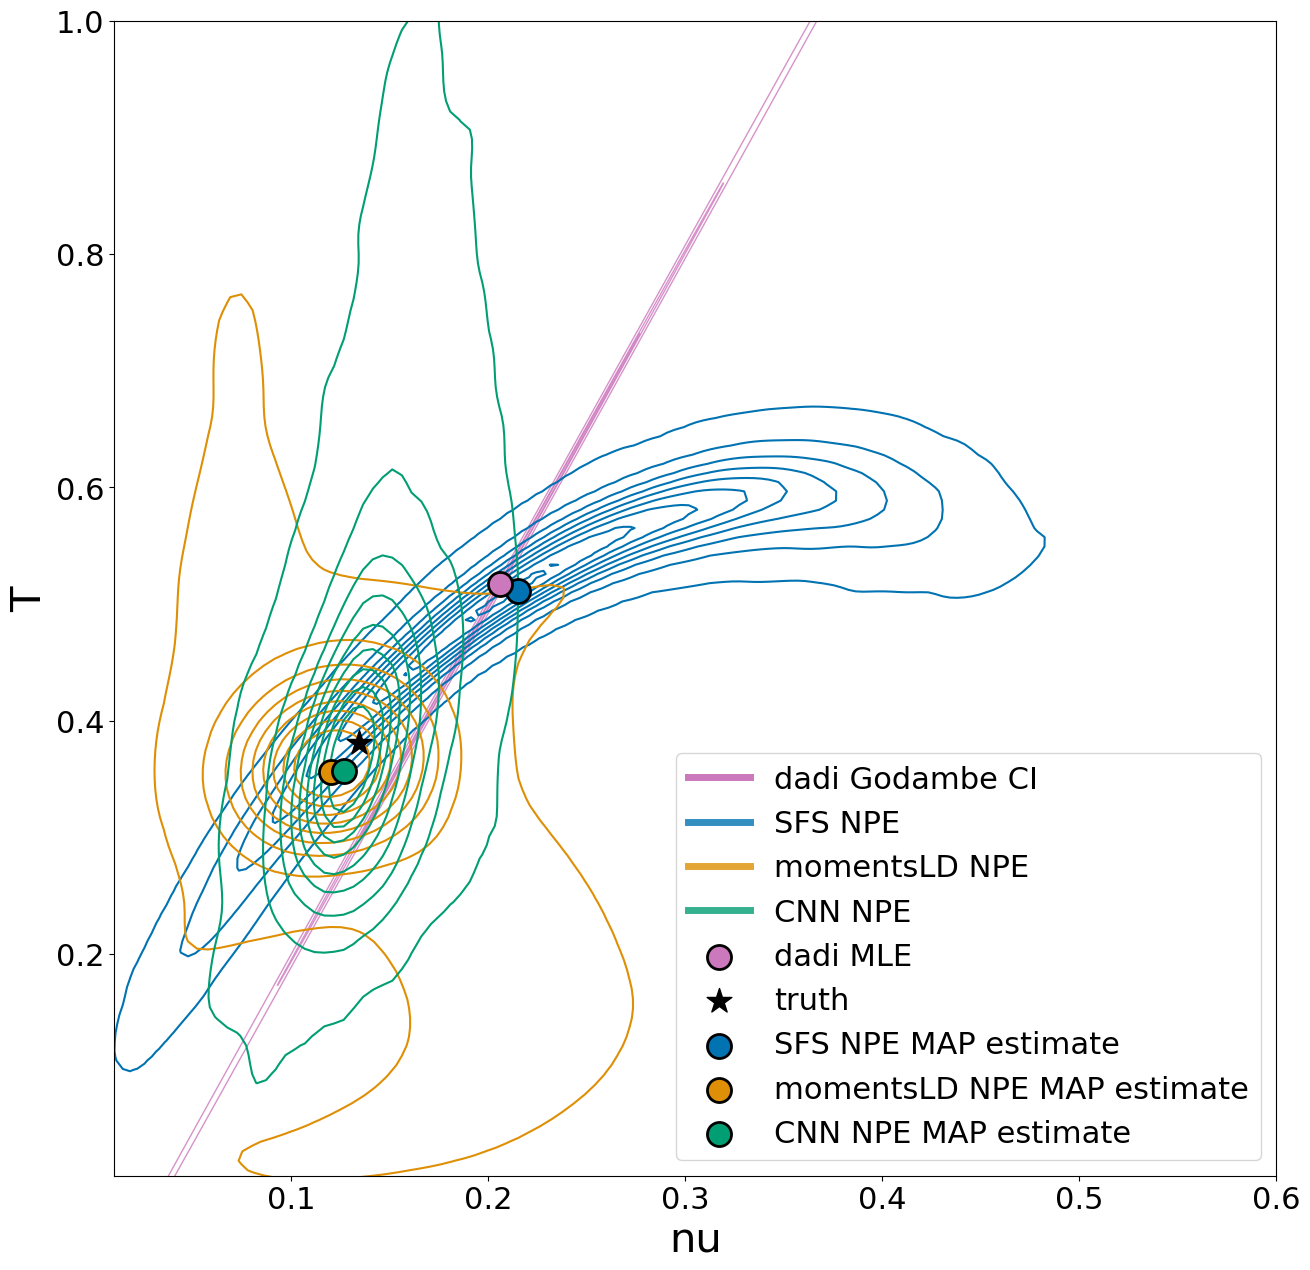

In [10]:
from scipy import stats

colors = sns.color_palette("colorblind")
color_dict = {
    "SFS + no embedding": colors[0], 
    "momentsLD + MLP": colors[1],
    "genotype matrix + ExchangeableCNN": colors[2],
    "dadi": colors[4]
}

label_dict = {
    "SFS + no embedding": "SFS NPE",
    "momentsLD + MLP": "momentsLD NPE",
    "genotype matrix + ExchangeableCNN": "CNN NPE",
    "dadi": "dadi Godambe"
}
fig, ax = plt.subplots(figsize=(15, 15))

# draw ellipses from the Godambe Information Matrix
vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
scalars = [0.5, 0.8, 2]

ellipses = []
for scale in scalars:
    width = 2 * scale * np.sqrt(vals[0])
    height = 2 * scale * np.sqrt(vals[1])
    ellipse = Ellipse(
        xy=MLE,
        width=width,
        height=height,
        angle=theta,
        alpha=0.8,
        fill=False,
        color=color_dict["dadi"],
    )
    ellipses.append(ax.add_artist(ellipse))
# Add a single legend entry for all ellipses
ellipse_legend = plt.Line2D(
    [],
    [],
    color=color_dict["dadi"],
    linestyle="-",
    linewidth=5,
    alpha=1,
    label="dadi Godambe CI",
)

kde_plot = sns.kdeplot(
        data=posterior_pd, 
        x="nu", 
        y="T", 
        hue="method", 
        ax=ax, 
        legend=False, 
        alpha=1,
        palette=color_dict,
)  # levels=[0.05])
kde_methods = posterior_pd["method"].unique()
kde_handles = [
    plt.Line2D(
        [],
        [],
        color=color_dict[method],
        linestyle="-",
        linewidth=5,
        alpha=0.8,
        label=f"{label_dict[method]}",
    )
    for method in kde_methods
]
MAP_points = []
for method in posterior_pd["method"].unique():
    method_data = posterior_pd[posterior_pd["method"] == method]

    # Calculate the 2D KDE
    kde = stats.gaussian_kde(method_data[["nu", "T"]].values.T)

    # Create a grid of points
    nu_range = np.linspace(method_data["nu"].min(), method_data["nu"].max(), 100)
    T_range = np.linspace(method_data["T"].min(), method_data["T"].max(), 100)
    nu_grid, T_grid = np.meshgrid(nu_range, T_range)
    positions = np.vstack([nu_grid.ravel(), T_grid.ravel()])

    # Evaluate KDE on the grid
    kde_values = kde(positions).reshape(nu_grid.shape)

    # Find the point of maximum density
    max_idx = np.unravel_index(kde_values.argmax(), kde_values.shape)
    max_nu, max_T = nu_range[max_idx[1]], T_range[max_idx[0]]

    # Plot the point of maximum density
    MAP_points.append(
        ax.scatter(
            max_nu,
            max_T,
            color=color_dict[method],
            s=300,
            zorder=10,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label=f"{label_dict[method]} MAP estimate",
        )
    )

# place a marker on the MLE
marker_handles = [
    ax.scatter(
        MLE[0], 
        MLE[1], 
        s=300, 
        color=color_dict["dadi"],
        marker="o",
        edgecolors="black",
        linewidth=2,
        zorder=10, 
        label="dadi MLE"
    ),
    # place a marker on the truth
    ax.scatter(
        nu_true, 
        T_true, 
        s=350, 
        marker="*", 
        color="k", 
        zorder=10, 
        label="truth"
    )
]

all_handles = [ellipse_legend] + kde_handles + marker_handles + MAP_points 
ax.set_xlim((lower_bound[0], 0.6))
ax.set_ylim((lower_bound[1], 1))
ax.set_xlabel("nu", fontsize=30)
ax.set_ylabel("T", fontsize=30)
# place a marker on the posterior mean of the posterior_pd
ax.legend(handles=all_handles, loc="lower right")
plt.savefig("posterior_comparison.pdf")

Alternatively, we can resample from the observed SFS to create bootstrap data.
The upside is that we are no longer limited by the short sequence length (10MB) and can make as many bootstrap data as we want. 
The limitation is that it assumes that each locus is independent from each other.

In [15]:
boots2 = []
for i in range(100):
    random.seed(2468+i)
    fs_resample = dadi.Spectrum(ts.allele_frequency_spectrum(polarised=True, span_normalise=False, mode="site")).sample()
    boots2.append(fs_resample)


In [16]:
MLE = np.load("dadi_mle_redo.npy")
fs_o = dadi.Spectrum(ts.allele_frequency_spectrum(polarised=True, span_normalise=False, mode="site"))

In [17]:
random.seed(1357)
np.random.seed(1357)
uncerts_adj, GIM, H = dadi.Godambe.GIM_uncert(
    func_ex,
    pts_l,
    boots2, 
    MLE,
    fs_o,
    eps=0.001,
    return_GIM=True,
    multinom=False,
)
cov = np.linalg.inv(GIM)
print(cov)


[[0.01993194 0.06055039]
 [0.06055039 0.18394893]]


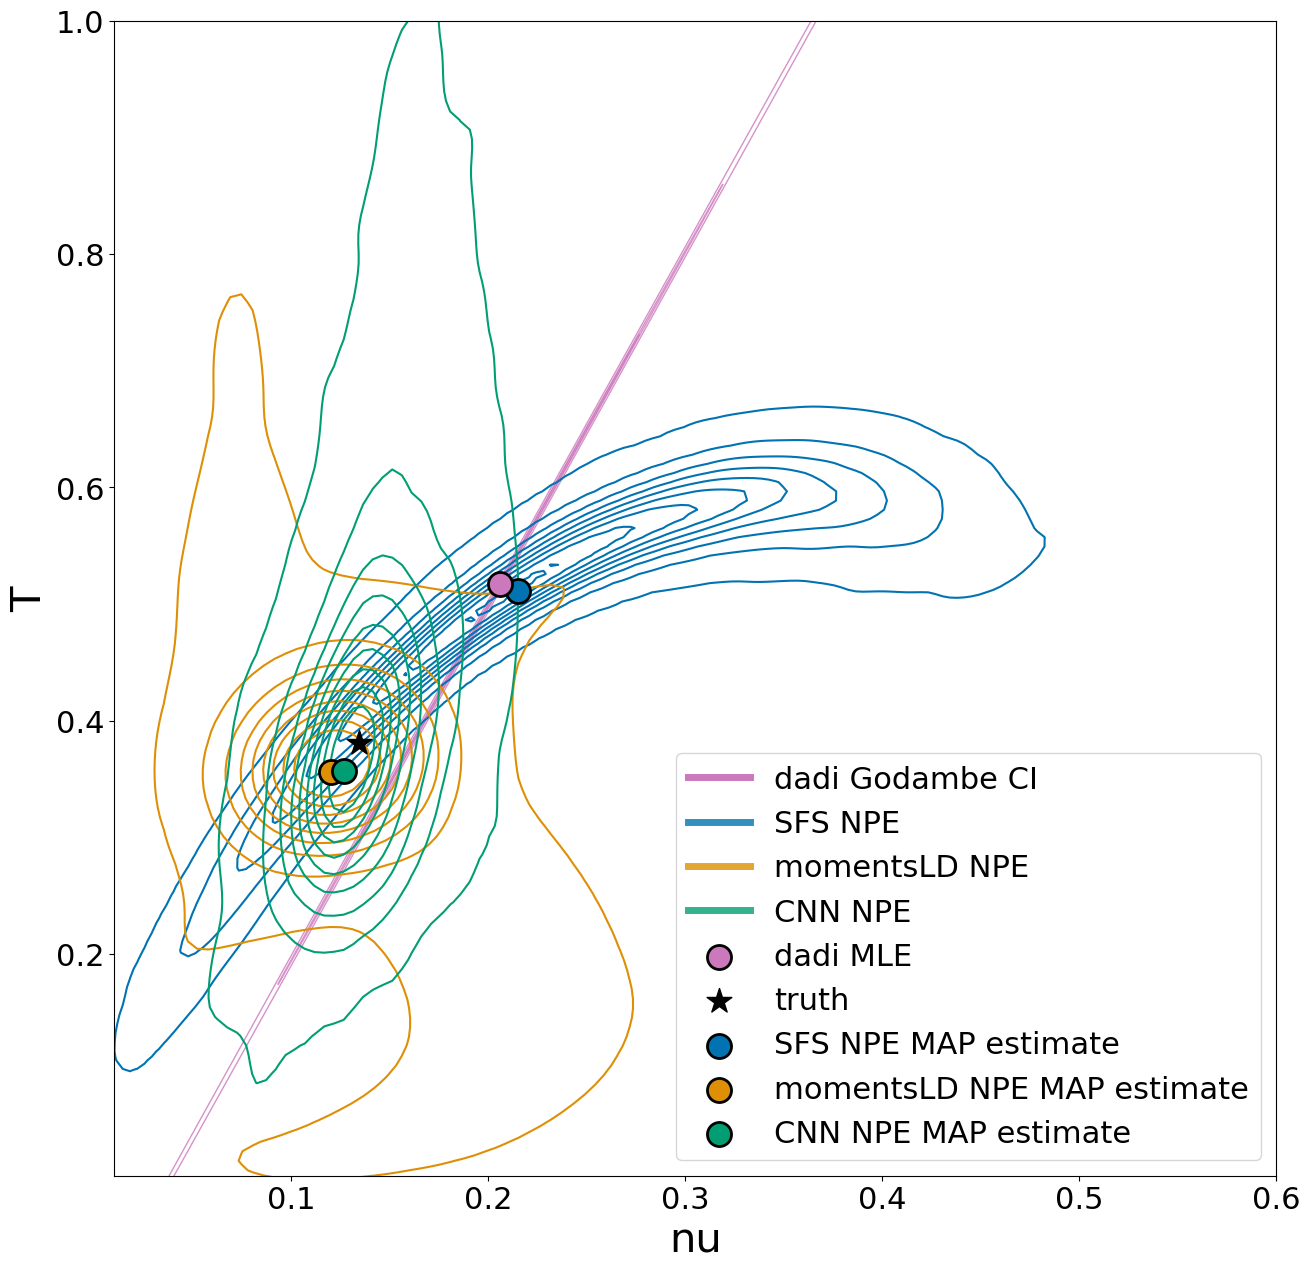

In [18]:
# Draw the uncertainty ellipses with posterior KDEs again
fig, ax = plt.subplots(figsize=(15, 15))

# draw ellipses from the Godambe Information Matrix
vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
scalars = [0.5, 0.8, 2]

ellipses = []
for scale in scalars:
    width = 2 * scale * np.sqrt(vals[0])
    height = 2 * scale * np.sqrt(vals[1])
    ellipse = Ellipse(
        xy=MLE,
        width=width,
        height=height,
        angle=theta,
        alpha=0.8,
        fill=False,
        color=color_dict["dadi"],
    )
    ellipses.append(ax.add_artist(ellipse))
# Add a single legend entry for all ellipses
ellipse_legend = plt.Line2D(
    [],
    [],
    color=color_dict["dadi"],
    linestyle="-",
    linewidth=5,
    alpha=1,
    label="dadi Godambe CI",
)

kde_plot = sns.kdeplot(
        data=posterior_pd, 
        x="nu", 
        y="T", 
        hue="method", 
        ax=ax, 
        legend=False, 
        alpha=1,
        palette=color_dict,
)  # levels=[0.05])
kde_methods = posterior_pd["method"].unique()
kde_handles = [
    plt.Line2D(
        [],
        [],
        color=color_dict[method],
        linestyle="-",
        linewidth=5,
        alpha=0.8,
        label=f"{label_dict[method]}",
    )
    for method in kde_methods
]
MAP_points = []
for method in posterior_pd["method"].unique():
    method_data = posterior_pd[posterior_pd["method"] == method]

    # Calculate the 2D KDE
    kde = stats.gaussian_kde(method_data[["nu", "T"]].values.T)

    # Create a grid of points
    nu_range = np.linspace(method_data["nu"].min(), method_data["nu"].max(), 100)
    T_range = np.linspace(method_data["T"].min(), method_data["T"].max(), 100)
    nu_grid, T_grid = np.meshgrid(nu_range, T_range)
    positions = np.vstack([nu_grid.ravel(), T_grid.ravel()])

    # Evaluate KDE on the grid
    kde_values = kde(positions).reshape(nu_grid.shape)

    # Find the point of maximum density
    max_idx = np.unravel_index(kde_values.argmax(), kde_values.shape)
    max_nu, max_T = nu_range[max_idx[1]], T_range[max_idx[0]]

    # Plot the point of maximum density
    MAP_points.append(
        ax.scatter(
            max_nu,
            max_T,
            color=color_dict[method],
            s=300,
            zorder=10,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label=f"{label_dict[method]} MAP estimate",
        )
    )

# place a marker on the MLE
marker_handles = [
    ax.scatter(
        MLE[0], 
        MLE[1], 
        s=300, 
        color=color_dict["dadi"],
        marker="o",
        edgecolors="black",
        linewidth=2,
        zorder=10, 
        label="dadi MLE"
    ),
    # place a marker on the truth
    ax.scatter(
        nu_true, 
        T_true, 
        s=350, 
        marker="*", 
        color="k", 
        zorder=10, 
        label="truth"
    )
]

all_handles = [ellipse_legend] + kde_handles + marker_handles + MAP_points 
ax.set_xlim((lower_bound[0], 0.6))
ax.set_ylim((lower_bound[1], 1))
ax.set_xlabel("nu", fontsize=30)
ax.set_ylabel("T", fontsize=30)
# place a marker on the posterior mean of the posterior_pd
ax.legend(handles=all_handles, loc="lower right")
plt.savefig("posterior_comparison_dadi_resample_boots.pdf")

# Coverage Plot


In [5]:
npe_sfs_coverage = np.load("NPE_sfs_coverage.npy")
npe_momentsLD_coverage = np.load("NPE_momentsLD_coverage.npy")
npe_end2end_coverage = np.load("NPE_end2end_500SNPs_coverage.npy")
dadi_coverage = np.load("dadi_godambe_coverage.npy")
alpha_grid = np.arange(0.025, 0.5, 0.025)

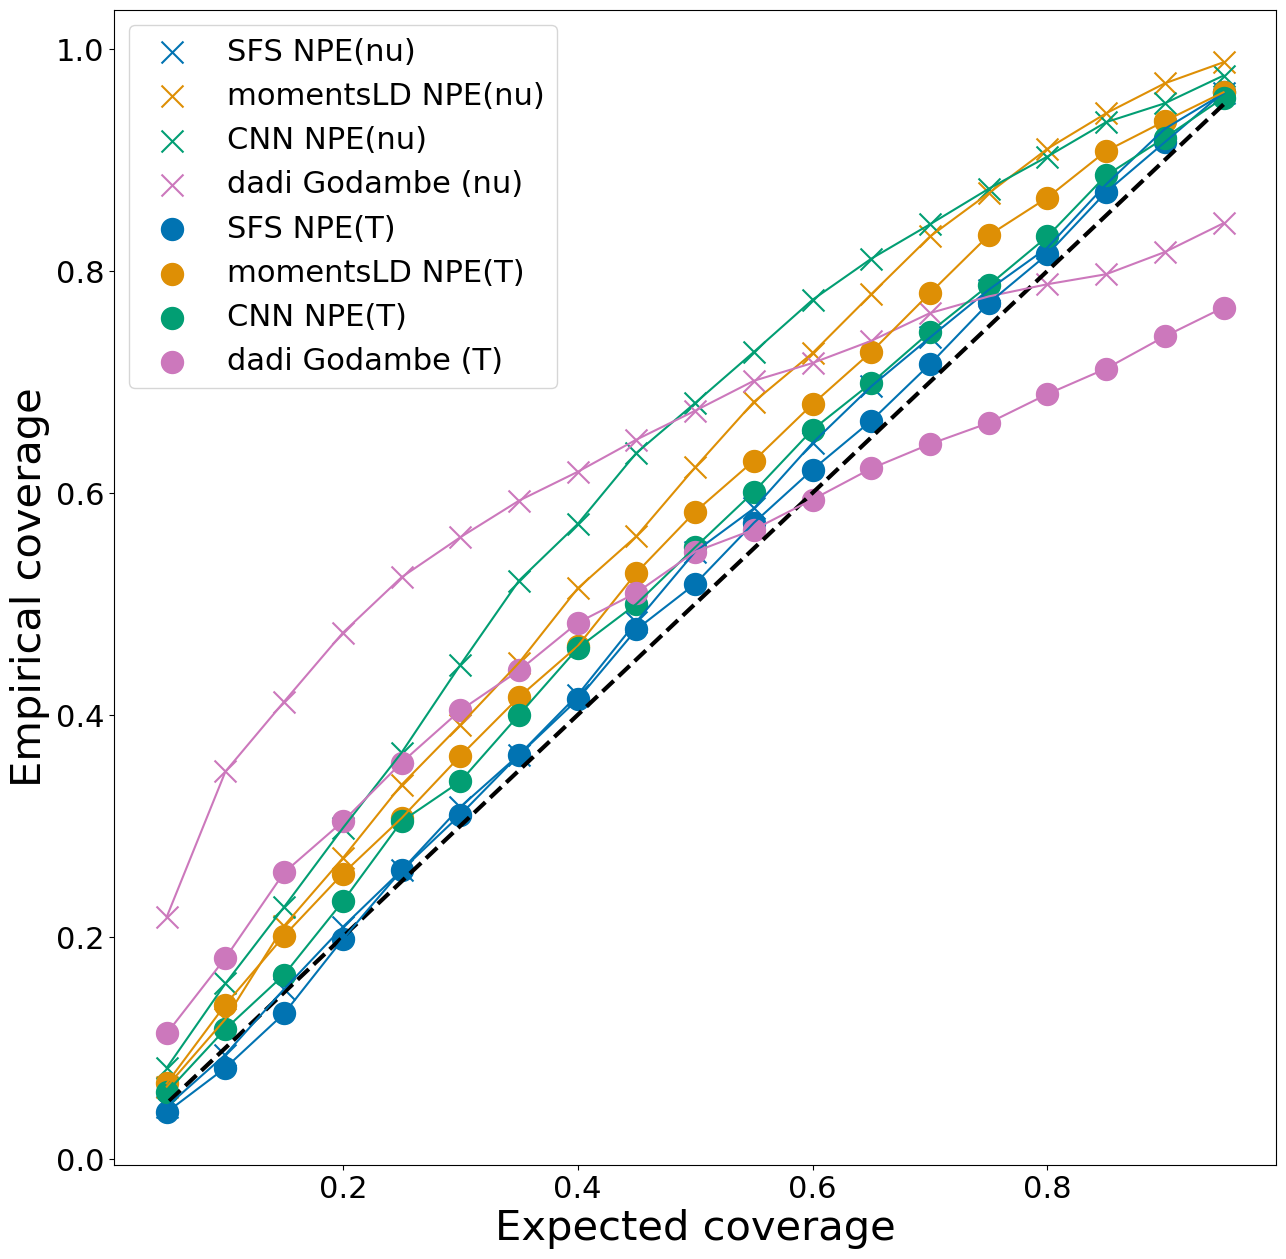

In [8]:
colors = sns.color_palette("colorblind")
color_dict = {
    "SFS + no embedding": colors[0], 
    "momentsLD + MLP": colors[1],
    "genotype matrix + ExchangeableCNN": colors[2],
    "dadi": colors[4]
}
label_dict = {
    "SFS + no embedding": "SFS NPE",
    "momentsLD + MLP": "momentsLD NPE",
    "genotype matrix + ExchangeableCNN": "CNN NPE",
    "dadi": "dadi Godambe"
}

fig, ax= plt.subplots(1,1, figsize=(15, 15))
param_names = ["nu", "T"]
markers = ["x", "o"]
ax.plot(1 - 2 * alpha_grid, 1 - 2 * alpha_grid, color='k', linestyle='--', linewidth=3)

for i, name in enumerate(param_names):
    ax.scatter(
        1 - 2 * alpha_grid,
        npe_sfs_coverage[i],
        s=250,
        marker=markers[i],
        color=color_dict["SFS + no embedding"],
        label=f"{label_dict['SFS + no embedding']}({param_names[i]})",
    )
    ax.plot(1 - 2 * alpha_grid, npe_sfs_coverage[i], color=color_dict["SFS + no embedding"])

    ax.scatter(
        1 - 2 * alpha_grid,
        npe_momentsLD_coverage[i],
        color=color_dict["momentsLD + MLP"],
        s=250,
        marker=markers[i],
        label=f"{label_dict['momentsLD + MLP']}({param_names[i]})",
    )
    ax.plot(1 - 2 * alpha_grid, npe_momentsLD_coverage[i], color=color_dict["momentsLD + MLP"])

    ax.scatter(
        1 - 2 * alpha_grid,
        npe_end2end_coverage[i],
        s=250,
        marker=markers[i],
        color=color_dict["genotype matrix + ExchangeableCNN"],
        label=f"{label_dict['genotype matrix + ExchangeableCNN']}({param_names[i]})",
    )
    ax.plot(
        1 - 2 * alpha_grid,
        npe_end2end_coverage[i],
        color=color_dict["genotype matrix + ExchangeableCNN"],
    )

    ax.scatter(
        1 - 2 * alpha_grid,
        dadi_coverage[i],
        s=250,
        marker=markers[i],
        color=color_dict["dadi"],
        label=f"dadi Godambe ({(param_names[i])})",
    )
    ax.plot(1 - 2 * alpha_grid, dadi_coverage[i], color=color_dict["dadi"])
ax.legend()
ax.set_xlabel("Expected coverage", fontsize=30)
ax.set_ylabel("Empirical coverage", fontsize=30)
plt.savefig("coverage_comparison_all_in_single_panel.pdf")

In [ ]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]